# Preliminaries

## Libraries
We use scikit-learn library to achieve goals in task 1 & task 2. In addition, we use networkx library to perform propensity score matching at task 1.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx

sns.set(style="whitegrid")

## Theme for plots
Overall, we use seaborn to plot graphs and charts. We pick whitegrid for simplicity.

In [2]:
sns.set(style="whitegrid")

# Main Homework

## 1. Propensity Score Matching

Read data from the provided dataset and form raw dataframe.

In [25]:
# df_raw: bulk classic dataset from Robert LaLonde's study 
dataset_file = 'lalonde.csv'
df_raw       = pd.read_csv(dataset_file)

# print general information of the datasets
print("Number of subjects: ",df_raw.shape[0])

# preview the data
display(df_raw.head(5))

Number of subjects:  614


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### 1a. Naive Analysis

First, we split data into two groups, treatment and control, based on treatment on subject or not (treat 1 or 0)

In [23]:
# split using predefined function split_data
def split_data(df):
    return df.loc[df["treat"]==1], df.loc[df["treat"]==0]

df_treated_raw, df_control_raw = split_data(df_raw)

# print number of treated and control subjects
print("Number of treated subjects: ",df_treated_raw.shape[0])
print("Number of control subjects: ",df_control_raw.shape[0])

Number of treated subjects:  185
Number of control subjects:  429


* We discover that zeros are frequently presence in re78 column. Zeros mean unemployed condition (no salaries) and thus we cannot really analyze the results of job training program. Because we strictly rely with real earnings in 1978 to determine the outcome of job training program, there will be some cases where we decide to ignore zeros.
* Hence we create dataframes with zeros replaces with NaN. By default, pandas operation will not include zeros entries and we can count statistics of the rest non-zeros values.

In [10]:
# we don't want to account for zero, thus we show the dataframe with NaN
# note that this replaces binaries features as well, but we can ignore that since here at this point we focus on re78
df_treated_with_nan    = df_treated_raw.replace(0,np.NAN)
df_control_with_nan    = df_control_raw.replace(0,np.NAN)

Then, we compare 4 different statistics of re78:
1. Earnings in 78 of **treated group (NSW)**
2. Earnings in 78 of **control group (PSID)**
3. Earnings in 78 of **treated group (NSW)**, employed subject only (ignore subject with zeros earnings)
4. Earnings in 78 of **control group (PSID)**, employed subject only (ignore subject with zeros earnings)

In [14]:
print("Re78 statistics of Treated vs Control Group")

# form stats dataframe
stats         = pd.DataFrame(df_treated_raw.describe()[['re78']])
stats.columns = ["treated_re78"]

# add statistics of re78
stats["control_re78"]                     = df_control_raw.describe()[['re78']]
stats["treated_re78_without_unemployed"]  = df_treated_with_nan.describe()[['re78']]
stats["control_re78_without_unemployed"]  = df_control_with_nan.describe()[['re78']]

display(stats)

Re78 statistics of Treated vs Control Group


,treated_re78,control_re78,treated_re78_without_unemployed,control_re78_without_unemployed
count,185.000000,429.000000,140.000000,331.000000
mean,6349.143530,6984.169742,8389.939665,9051.990391
std,7867.402218,7294.161791,8042.944693,7087.340468
min,0.000000,0.000000,289.789900,31.032260
25%,485.229800,220.181300,3167.353750,2978.358000
50%,4232.309000,4975.505000,6504.144500,7310.313000
75%,9642.999000,11688.820000,11017.730000,14131.500000
max,60307.930000,25564.670000,60307.930000,25564.670000


#### Distribution of re78 between two groups - Include outliers and zeros (unemployed subjects)
Now we want to see the distributions of outcome variable re78 between two groups.
<br>First we see the distributions when we include zeros and outliers

Mean earnings in 1978 of Treated group:  6349.143530270269
Median earnings in 1978 of Treated group:  4232.309
Mean earnings in 1978 of Control group:  6984.169742307697
Median earnings in 1978 of Control group:  4975.505


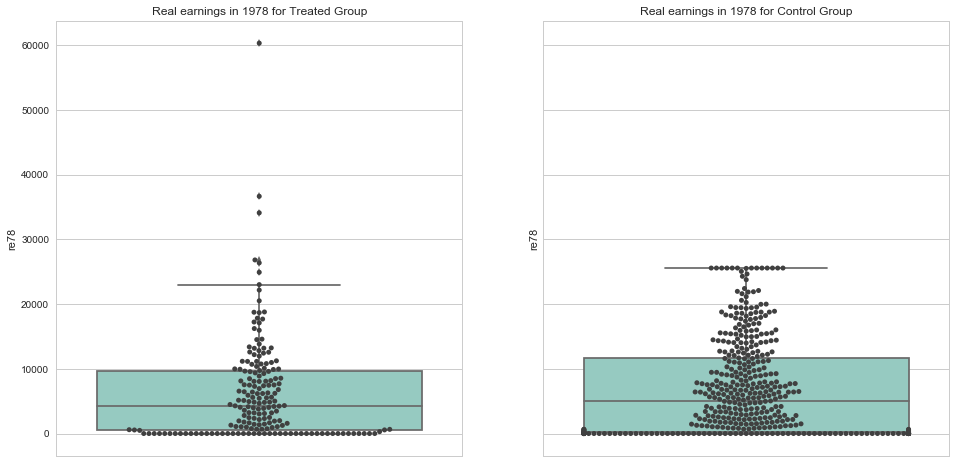

In [42]:
# Plot 2 x 1
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(16, 8)
ax1 = sns.boxplot(y = 're78', data=df_treated_raw, ax = ax1, palette="Set3")
ax1 = sns.swarmplot(y = 're78', data=df_treated_raw, ax = ax1, color=".25")
ax1.set_title("Real earnings in 1978 for Treated Group")

ax2 = sns.boxplot(y = 're78', data=df_control_raw, ax = ax2, palette="Set3")
ax2 = sns.swarmplot(y = 're78', data=df_control_raw, ax = ax2, color=".25")
ax2.set_title("Real earnings in 1978 for Control Group")

# Print mean and median of re78 between two groups
print("Mean earnings in 1978 of Treated group: ", df_treated_raw['re78'].mean())
print("Median earnings in 1978 of Treated group: ", df_treated_raw['re78'].median())
print("Mean earnings in 1978 of Control group: ", df_control_raw['re78'].mean())
print("Median earnings in 1978 of Control group: ", df_control_raw['re78'].median())

#### Observing outliers in treated group & zeros earnings in both group
As we can see in above figure, there are several outliers in treated group with earnings of almost 10 times larger than the average group earnings.

In [27]:
# consider outliers are ones with re78 > 20000
df_treated_raw_outliers = df_treated_raw.loc[df_treated_raw['re78'] > 20000]

# inspect zeros
n_zeros_treated_raw = df_treated_raw.loc[df_treated_raw["re78"]==0].shape[0]
n_zeros_control_raw = df_control_raw.loc[df_control_raw["re78"]==0].shape[0]

print("Number of outliers in treated group: ", df_treated_raw_outliers.shape[0])
print("Number of zeros earnings in 1978 of treated group: ", n_zeros_treated_raw)
print("Number of zeros earnings in 1978 of control group: ", n_zeros_control_raw)

display(df_treated_raw_outliers.head(5))

Number of outliers in treated group:  9
Number of zeros earnings in 1978 of treated group:  45
Number of zeros earnings in 1978 of control group:  98


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.45
35,NSW36,1,42,14,1,0,0,0,0.0,0.0,20505.93
78,NSW79,1,40,11,1,0,0,1,0.0,0.0,23005.60
99,NSW100,1,31,9,0,1,0,1,0.0,0.0,26817.60
106,NSW107,1,27,13,1,0,0,0,0.0,0.0,34099.28


It is astonishing to see **45 out of 185** and **98 out of 429** (almost quarter each) subjects in treated group  and control group are unemployed persons. Thus this bold our reason to plot only non-zeros values of re78.

#### Distribution of re78 between two groups - Exclude outliers and zeros (unemployed subjects)
Then let's see the distributions when we exclude zeros and outliers from both group

Average earnings in 1978 of Treated group (zeros excluded):  8389.939665
Median earnings in 1978 of Treated group (zeros excluded):  6504.144499999999
Average earnings in 1978 of Control group (zeros excluded):  9051.990391087618
Median earnings in 1978 of Control group (zeros excluded):  7310.313


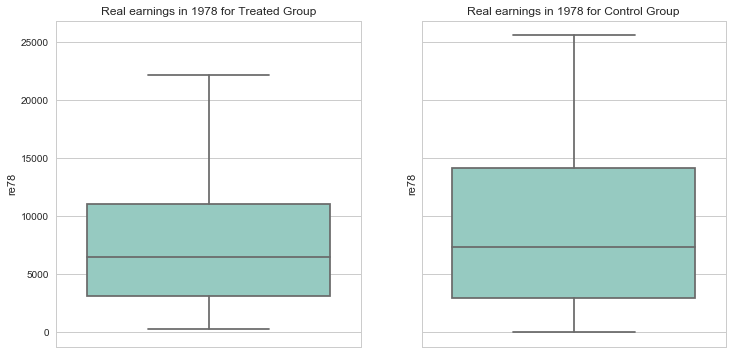

In [44]:
# Plot 2 x 1
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(12, 6)
ax1 = sns.boxplot(y = 're78' , data=df_treated_with_nan, ax = ax1, palette="Set3", showfliers=False)
ax1.set_title("Real earnings in 1978 for Treated Group")

ax2 = sns.boxplot(y = 're78' , data=df_control_with_nan, ax = ax2, palette="Set3", showfliers=False)
ax2.set_title("Real earnings in 1978 for Control Group")

print("Average earnings in 1978 of Treated group (zeros excluded): ",df_treated_with_nan['re78'].mean())
print("Median earnings in 1978 of Treated group (zeros excluded): ",df_treated_with_nan['re78'].median())
print("Average earnings in 1978 of Control group (zeros excluded): ",df_control_with_nan['re78'].mean())
print("Median earnings in 1978 of Control group (zeros excluded): ",df_control_with_nan['re78'].median())

### Naive observations

At this point, naive researchers may conclude that:
1. There is **no impact of job training program** to subject's earning as outcome (re78). Subjects in treated group tends to have lower outcome as we can see from both their earnings mean and median. Recall that median is sensitive to outliers.
2. The training is effective only to specific indivinduals, several subjects whom we can see as outliers in treated group.

### 1b. A Closer Look Into the Data
Now we delve deeper into distibutions of features between two groups. We can separate the analysis based on:
1. Binary features (either one or zero/ yes or no): { black, hispan, married, nodegree }
2. Continuous features : { age, educ, re74, re75 }

In [28]:
# first lets peek for number of data in each group
n_treated_raw = df_treated_raw.shape[0]
n_control_raw = df_control_raw.shape[0]

print("Number of Treated Subjects: ", n_treated_raw)
print("Number of Control Subjects: ", n_control_raw)

Number of Treated Subjects:  185
Number of Control Subjects:  429


#### Binary Features (black, hispan, married, nodegree)
Please note that to see distribution of binary features, it is better if we see the distribution in form of percentages. As we can see that the number of subject is imbalance between two groups (n_control > n_treated)

In [31]:
# gather the number of black, hispan, married, and nodegree subjects for both treated and control group
n_black_treated_raw    = df_treated_raw.loc[df_treated_raw["black"]==1].shape[0]
n_black_control_raw    = df_control_raw.loc[df_control_raw["black"]==1].shape[0]
n_hispan_treated_raw   = df_treated_raw.loc[df_treated_raw["hispan"]==1].shape[0]
n_hispan_control_raw   = df_control_raw.loc[df_control_raw["hispan"]==1].shape[0]
n_married_treated_raw  = df_treated_raw.loc[df_treated_raw["married"]==1].shape[0]
n_married_control_raw  = df_control_raw.loc[df_control_raw["married"]==1].shape[0]
n_nodegree_treated_raw = df_treated_raw.loc[df_treated_raw["nodegree"]==1].shape[0]
n_nodegree_control_raw = df_control_raw.loc[df_control_raw["nodegree"]==1].shape[0]

print("Number of Black Subject in Treated Group: ",n_black_treated_raw)
print("Number of Black Subject in Control Group: ",n_black_control_raw)
print("Number of Hispan Subject in Treated Group: ",n_hispan_treated_raw)
print("Number of Hispan Subject in Control Group: ",n_hispan_control_raw)
print("Number of Married Subject in Treated Group: ",n_married_treated_raw)
print("Number of Married Subject in Control Group: ",n_married_control_raw)
print("Number of Nodegree Subject in Treated Group: ",n_nodegree_treated_raw)
print("Number of Nodegree Subject in Control Group: ",n_nodegree_control_raw)

Number of Black Subject in Treated Group:  156
Number of Black Subject in Control Group:  87
Number of Hispan Subject in Treated Group:  11
Number of Hispan Subject in Control Group:  61
Number of Married Subject in Treated Group:  35
Number of Married Subject in Control Group:  220
Number of Nodegree Subject in Treated Group:  131
Number of Nodegree Subject in Control Group:  256


To later plot the distribution, we calcuate the percentage of every binary feature in each group.

In [32]:
# percentage_of_feature = count(features) / n_data
pr_black_treated_raw    = n_black_treated_raw    / n_treated_raw
pr_black_control_raw    = n_black_control_raw    / n_control_raw
pr_hispan_treated_raw   = n_hispan_treated_raw   / n_treated_raw
pr_hispan_control_raw   = n_hispan_control_raw   / n_control_raw
pr_married_treated_raw  = n_married_treated_raw  / n_treated_raw
pr_married_control_raw  = n_married_control_raw  / n_control_raw
pr_nodegree_treated_raw = n_nodegree_treated_raw / n_treated_raw
pr_nodegree_control_raw = n_nodegree_control_raw / n_control_raw

Now we form dataframe of percentage of binary features

In [36]:
data = {
        'features':['black','hispan','married','nodegree'],
        'pr_treated':[pr_black_treated_raw, pr_hispan_treated_raw, pr_married_treated_raw, pr_nodegree_treated_raw],
        'pr_control':[pr_black_control_raw, pr_hispan_control_raw, pr_married_control_raw, pr_nodegree_control_raw]
       }

# form dataframe of percentage of binary features
df_binary_features_pr = (pd.DataFrame(data, columns = ['features', 'pr_treated', 'pr_control']))
df_binary_features_pr

,features,pr_treated,pr_control
0,black,0.843243,0.202797
1,hispan,0.059459,0.142191
2,married,0.189189,0.512821
3,nodegree,0.708108,0.596737


#### Plotting Distribution of Binary Features (black, hispan, married, nodegree)

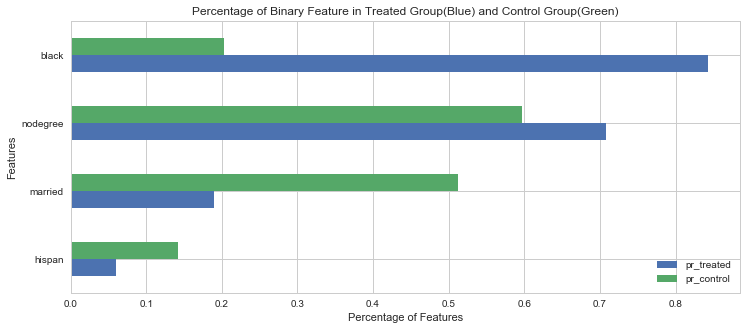

In [38]:
# use bar chart to depict percentage of binary values in dataset
ax = df_binary_features_pr.sort_values(["pr_treated"]) \
                          .plot.barh(y=["pr_treated","pr_control"],x=["features"], figsize=(12,5))
ax.set_xlabel('Percentage of Features');
ax.set_ylabel('Features');
ax.set_title('Percentage of Binary Feature in Treated Group(Blue) and Control Group(Green)');

#### Plotting Continous Features (age, educ, re74, re75) - Box Plots (without outliers)

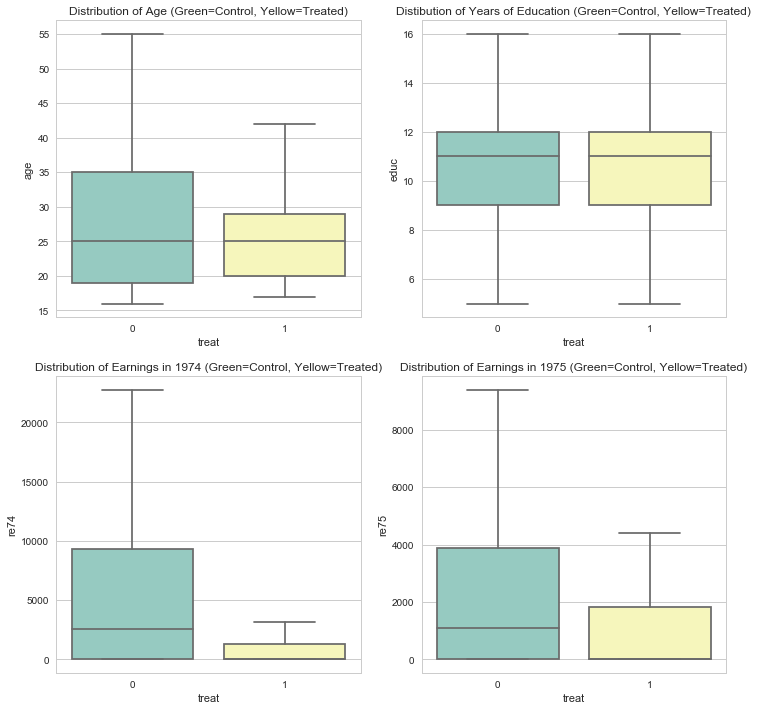

In [47]:
# Plot 2 x 2
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 12)
ax1 = sns.boxplot(y="age", x="treat", ax=ax1, data=df_raw, palette="Set3", showfliers=False)
ax1.set_title("Distribution of Age (Green=Control, Yellow=Treated)")

ax2 = sns.boxplot(y="educ", x="treat", ax=ax2, data=df_raw, palette="Set3", showfliers=False)
ax2.set_title("Distibution of Years of Education (Green=Control, Yellow=Treated)")

ax3 = sns.boxplot(y="re74", x="treat", ax=ax3, data=df_raw, palette="Set3", showfliers=False)
ax3.set_title("Distribution of Earnings in 1974 (Green=Control, Yellow=Treated)")

ax4 = sns.boxplot(y="re75", x="treat", ax=ax4, data=df_raw, palette="Set3", showfliers=False)
ax4.set_title("Distribution of Earnings in 1975 (Green=Control, Yellow=Treated)")

We can sure from boxplot above that there are plenty of zeros present in re74 and re75.
As we see that the mean for treated group is close to zero.

#### Plotting Continous Features (age, educ, re74, re75) - Distribution Plot With Outliers
Disclaimer: Although there are zeros in re74 and re75, we cannot just exclude these values since we assume that job training program made unemployed subjects in 1974 and 1975 gained job in 1978.

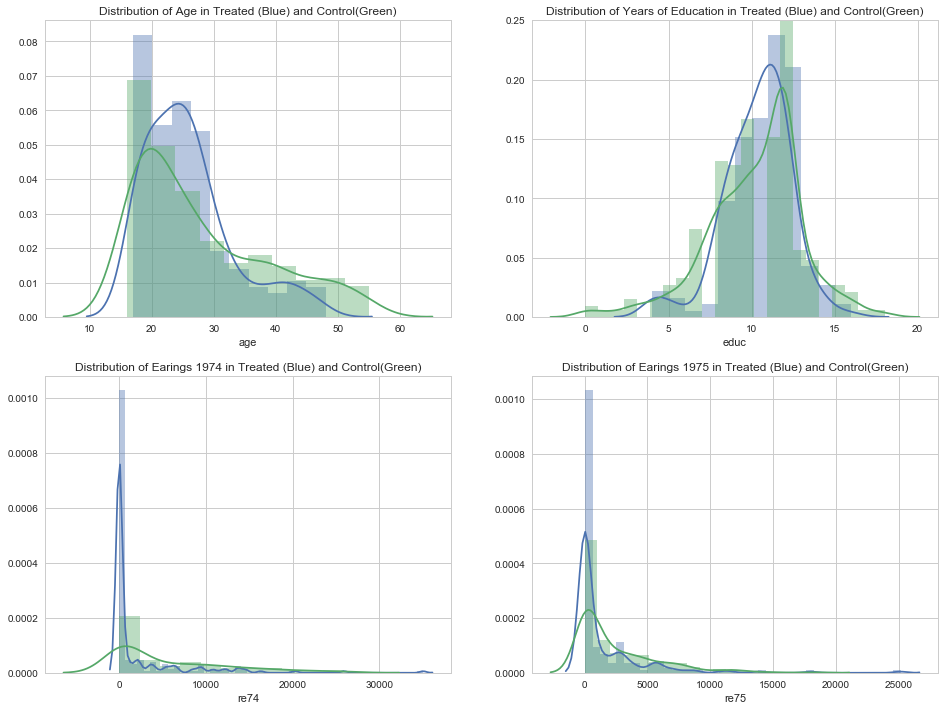

In [48]:
# Plot 2 x 2
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 12)

ax1 = sns.distplot(df_treated_raw['age'], ax=ax1)
ax1 = sns.distplot(df_control_raw['age'], ax=ax1)
ax1.set_title("Distribution of Age in Treated (Blue) and Control(Green)")

ax2 = sns.distplot(df_treated_raw['educ'], ax=ax2)
ax2 = sns.distplot(df_control_raw['educ'], ax=ax2)
ax2.set_title("Distribution of Years of Education in Treated (Blue) and Control(Green)")

ax3 = sns.distplot(df_treated_raw['re74'], ax=ax3)
ax3 = sns.distplot(df_control_raw['re74'], ax=ax3)
ax3.set_title("Distribution of Earings 1974 in Treated (Blue) and Control(Green)")

ax4 = sns.distplot(df_treated_raw['re75'], ax=ax4)
ax4 = sns.distplot(df_control_raw['re75'], ax=ax4)
ax4.set_title("Distribution of Earings 1975 in Treated (Blue) and Control(Green)")


### Observations - Superficial Analysis

TBD

### 1c. Propensity Score Model

In [21]:
features = ['age','educ','black','hispan','married','nodegree','re74','re75']

lr = LogisticRegression()
lr.fit(df_combined[features], df_combined.treat)

for f in range(len(features)):
    print("{0} * {1} + ".format(lr.coef_[0][f], features[f]))
print(lr.intercept_)

-0.006794203196110479 * age + 
-0.06602229032932304 * educ + 
2.584312591779158 * black + 
-0.04066538431557746 * hispan + 
-0.8414791177767145 * married + 
-0.36073074385840437 * nodegree + 
-7.541707841613298e-05 * re74 + 
5.759219439211685e-05 * re75 + 
[-0.63204745]


$$y = \beta_0 + \beta_1  \times educ + \beta_2  \times black + \beta_3  \times hispan + \beta_4  \times married + \beta_5  \times nodegree + \beta_6  \times re74 + \beta_7  \times re75$$
$$y = -0.6320 - 0.0068 \times age - 0.0660 \times educ + 2.5843  \times black - 0.0407 \times hispan - 0.8415 \times married - 0.3607 \times nodegree - 7.5417 \times re74 + 5.7592 \times re75$$

In [22]:
# Pick only the score of going into treated
pred = pd.DataFrame(lr.predict_proba(df_combined[features])[:,1])
pred.columns = ["propensity_score"]
pred.head(5)

,propensity_score
0,0.443350
1,0.144660
2,0.722355
3,0.664151
4,0.698286


In [23]:
df_combined_prop_scr                     = df_combined
df_combined_prop_scr['propensity_score'] = pred['propensity_score']

df_control_prop_scr = df_combined_prop_scr.loc[df_combined_prop_scr['treat']==0]
df_treated_prop_scr = df_combined_prop_scr.loc[df_combined_prop_scr['treat']==1]

display(df_control_prop_scr.head(5))
display(df_treated_prop_scr.head(5))

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
185,PSID1,0,30,12,0,0,1,0,20166.73,18347.23,25564.67,0.050504
186,PSID2,0,26,12,0,0,1,0,25862.32,17806.55,25564.67,0.033330
187,PSID3,0,25,16,0,0,1,0,25862.32,15316.21,25564.67,0.022574
188,PSID4,0,42,11,0,0,1,1,21787.05,14265.29,15491.01,0.024906
189,PSID5,0,25,9,1,0,1,1,14829.69,13776.53,0.00,0.416054


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


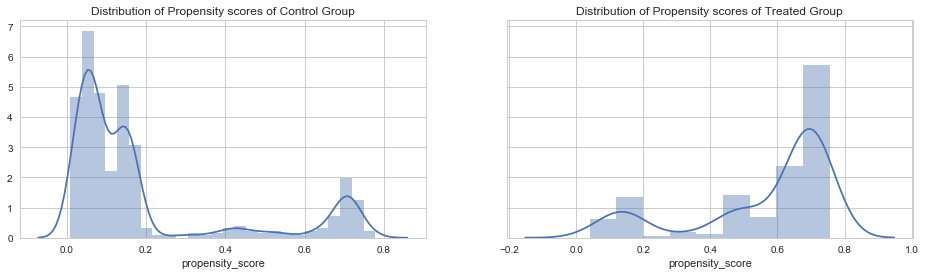

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(16, 4)
ax1 = sns.distplot(df_control_prop_scr['propensity_score'], ax = ax1)
ax1.set_title("Distribution of Propensity scores of Control Group")

ax2 = sns.distplot(df_treated_prop_scr['propensity_score'], ax = ax2)
ax2.set_title("Distribution of Propensity scores of Treated Group")

### Observations - Propensity Score Matching with Logistic Regression

TBD

### 1d. Balancing dataset via matching Propensity Score

In [25]:
df_pr_weights = pd.DataFrame()
for row in df_control_prop_scr[['id','propensity_score']].iterrows():
    id      = row[1][0]
    pr_ctrl = row[1][1]
    weights = -1 * abs(pr_ctrl - df_treated_prop_scr.propensity_score)
    df_pr_weight            = pd.DataFrame(df_treated_prop_scr[['id']])
    df_pr_weight.columns    = [['b']]
    df_pr_weight['0']       = id
    df_pr_weight["weights"] = pd.DataFrame(weights)    
    df_pr_weights           = pd.concat([df_pr_weights,df_pr_weight])

display(df_pr_weights.head(5))

,b,0,weights
0,NSW1,PSID1,-0.392846
1,NSW2,PSID1,-0.094156
2,NSW3,PSID1,-0.671851
3,NSW4,PSID1,-0.613647
4,NSW5,PSID1,-0.647782


In [28]:
G = nx.Graph()

G = nx.from_pandas_dataframe(df_pr_weights, '0', 'b', ['weights'])

match_control_treated = nx.max_weight_matching(G, maxcardinality=True)

In [29]:
display(df_combined.loc[df_combined['id']=="NSW11"])
display(df_combined.loc[df_combined['id']=="PSID419"])

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
10,NSW11,1,19,9,1,0,0,1,0.0,0.0,8173.908,0.70438


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
603,PSID419,0,51,4,1,0,0,1,0.0,0.0,0.0,0.727295


In [30]:
df_prop_merged            = pd.DataFrame(columns=["control","treated"])
df_prop_merged['treated'] = match_control_treated.keys()
df_prop_merged['control'] = match_control_treated.values()
df_prop_merged.head(5)

,control,treated
0,NSW1,PSID429
1,PSID429,NSW1
2,NSW2,PSID428
3,PSID428,NSW2
4,NSW3,PSID427


In [31]:
n_treated      = df_treated_prop_scr.shape[0]
df_prop_merged = df_prop_merged.sort_values(by="treated")[:n_treated]
df_prop_merged.head()

,control,treated
1,PSID429,NSW1
19,PSID420,NSW10
199,PSID330,NSW100
201,PSID329,NSW101
203,PSID328,NSW102


In [32]:
df_combined  = df_combined.set_index("id")

In [33]:
re78_control = df_combined.loc[df_prop_merged["control"]]["re78"]
re78_treated = df_combined.loc[df_prop_merged["treated"]]["re78"]

df_prop_merged["re78_control"] = list(re78_control)
df_prop_merged["re78_treated"] = list(re78_treated)
df_prop_merged.head()

,control,treated,re78_control,re78_treated
1,PSID429,NSW1,1495.4590,9930.046
19,PSID420,NSW10,964.9555,12418.070
199,PSID330,NSW100,116.7404,26817.600
201,PSID329,NSW101,1717.1180,0.000
203,PSID328,NSW102,14339.8600,9265.788


### Comparison of re78 after propensity score matching

In [34]:
df_prop_merged.describe()

,re78_control,re78_treated
count,185.000000,185.000000
mean,5525.962462,6349.143530
std,6637.979050,7867.402218
min,0.000000,0.000000
25%,0.000000,485.229800
50%,2813.591000,4232.309000
75%,8844.194000,9642.999000
max,25564.670000,60307.930000


Average earning of Control group (zeros excluded):  5525.962462378378
Median earning of Control group (zeros excluded):  2813.591
Average earning of Treated group (zeros excluded):  6349.1435302702685
Median earning of Treated group (zeros excluded):  4232.309


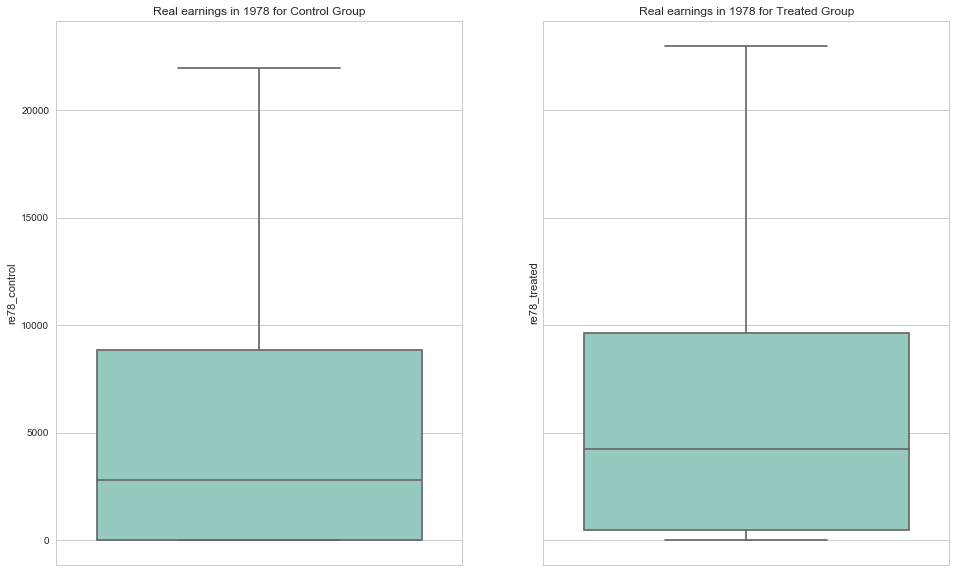

In [35]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(16, 10)
ax1 = sns.boxplot(y = 're78_control' , data=df_prop_merged, ax = ax1, palette="Set3", showfliers=False)
ax1.set_title("Real earnings in 1978 for Control Group")

ax2 = sns.boxplot(y = 're78_treated' , data=df_prop_merged, ax = ax2, palette="Set3", showfliers=False)
ax2.set_title("Real earnings in 1978 for Treated Group")

print("Average earning of Control group (zeros excluded): ",df_prop_merged['re78_control'].mean())
print("Median earning of Control group (zeros excluded): ",df_prop_merged['re78_control'].median())
print("Average earning of Treated group (zeros excluded): ",df_prop_merged['re78_treated'].mean())
print("Median earning of Treated group (zeros excluded): ",df_prop_merged['re78_treated'].median())

In [36]:
df_control = df_combined.loc[df_prop_merged["control"]]
df_treated = df_combined.loc[df_prop_merged["treated"]]

display(df_control.head(5))
display(df_treated.head(5))

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
id,,,,,,,,,,,
PSID429,0,16,9,0,0,0,1,0.000,0.0,1495.4590,0.155030
PSID420,0,39,2,1,0,1,1,0.000,0.0,964.9555,0.587354
PSID330,0,22,16,1,0,0,0,2564.680,0.0,116.7404,0.634835
PSID329,0,21,15,0,0,0,0,2629.336,0.0,1717.1180,0.123104
PSID328,0,29,13,0,0,1,0,2780.200,0.0,14339.8600,0.060738


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.046,0.443350
NSW10,1,33,12,0,0,1,0,0.0,0.0,12418.070,0.076562
NSW100,1,31,9,0,1,0,1,0.0,0.0,26817.600,0.137257
NSW101,1,24,10,1,0,0,1,0.0,0.0,0.000,0.683142
NSW102,1,26,10,1,0,0,1,0.0,0.0,9265.788,0.680194


### Post Propensity Matching: Observing Discrete Features (black, hispan, married, nodegree)

In [37]:
n_black_treated    = df_treated.loc[df_treated["black"]==1].shape[0]
n_black_control    = df_control.loc[df_control["black"]==1].shape[0]

n_hispan_treated   = df_treated.loc[df_treated["hispan"]==1].shape[0]
n_hispan_control   = df_control.loc[df_control["hispan"]==1].shape[0]

n_married_treated  = df_treated.loc[df_treated["married"]==1].shape[0]
n_married_control  = df_control.loc[df_control["married"]==1].shape[0]

n_nodegree_treated = df_treated.loc[df_treated["nodegree"]==1].shape[0]
n_nodegree_control = df_control.loc[df_control["nodegree"]==1].shape[0]

n_treated = df_treated.shape[0]
n_control = df_control.shape[0]

In [38]:
pr_black_treated    = n_black_treated / n_treated
pr_black_control    = n_black_control / n_control

pr_hispan_treated   = n_hispan_treated / n_treated
pr_hispan_control   = n_hispan_control / n_control

pr_married_treated  = n_married_treated / n_treated
pr_married_control  = n_married_control / n_control

pr_nodegree_treated = n_nodegree_treated / n_treated
pr_nodegree_control = n_nodegree_control / n_control

In [39]:
data = {
        'features':['black','hispan','married','nodegree'],
        'pr_treated':[pr_black_treated, pr_hispan_treated, pr_married_treated, pr_nodegree_treated],
        'pr_control':[pr_black_control, pr_hispan_control, pr_married_control, pr_nodegree_control]
       }

df_temp = (pd.DataFrame(data, columns = ['features', 'pr_treated', 'pr_control']))
df_temp

,features,pr_treated,pr_control
0,black,0.843243,0.275676
1,hispan,0.059459,0.118919
2,married,0.189189,0.410811
3,nodegree,0.708108,0.654054


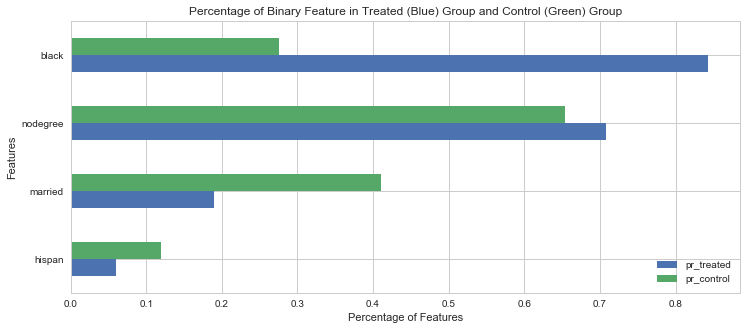

In [40]:
ax = df_temp.sort_values(["pr_treated"]).plot.barh(y=["pr_treated","pr_control"],x=["features"], figsize=(12,5))
ax.set_xlabel('Percentage of Features');
ax.set_ylabel('Features');
ax.set_title('Percentage of Binary Feature in Treated (Blue) Group and Control (Green) Group');

### Post Propensity Matching: Continous Features (age, educ, re74, re75) - Distribution Plot With Outliers

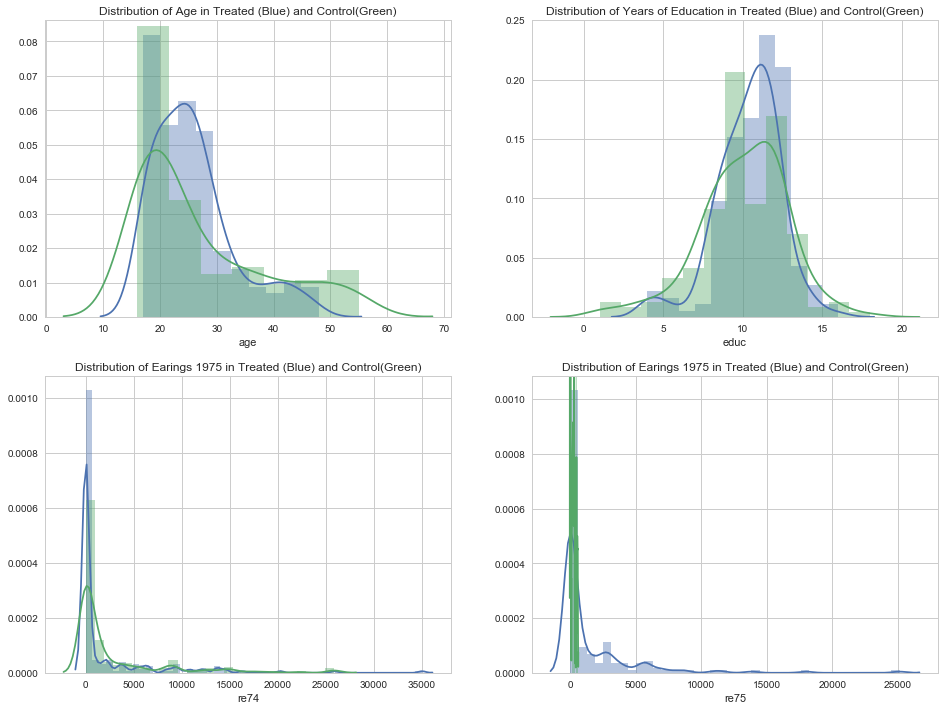

In [87]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 12)

ax1 = sns.distplot(df_treated['age'], ax=ax1)
ax1 = sns.distplot(df_control['age'], ax=ax1)
ax1.set_title("Distribution of Age in Treated (Blue) and Control(Green)")

ax2 = sns.distplot(df_treated['educ'], ax=ax2)
ax2 = sns.distplot(df_control['educ'], ax=ax2)
ax2.set_title("Distribution of Years of Education in Treated (Blue) and Control(Green)")

ax3 = sns.distplot(df_treated['re74'], ax=ax3)
ax3 = sns.distplot(df_control['re74'], ax=ax3)
ax3.set_title("Distribution of Earings 1975 in Treated (Blue) and Control(Green)")

ax4 = sns.distplot(df_treated['re75'], ax=ax4)
ax4 = sns.distplot(df_control['re75'], ax=ax4)
ax4.set_title("Distribution of Earings 1975 in Treated (Blue) and Control(Green)")


### We are not satisfied with the result!

### 1e. Balancing Groups Further, Features Matching
We can see from the plots that some features are not well distributed: black, married, and age.
Now we will redo the work in 1d. But we filter connection (vertices) from point to point based on these three features.

In [56]:
df_pr_weights = pd.DataFrame()
for row in df_control_prop_scr[['id','propensity_score','black','married']].iterrows():
    id      = row[1][0]
    pr_ctrl = row[1][1]
    black   = row[1][2]
    married = row[1][3]
    weights = -1 * abs(pr_ctrl - df_treated_prop_scr.loc[(df_treated_prop_scr["black"] == black ) \
                                                         & (df_treated_prop_scr["married"] == married)]
                                                        .propensity_score)
    df_pr_weight            = pd.DataFrame(df_treated_prop_scr[['id']])
    df_pr_weight.columns    = [['b']]
    df_pr_weight['0']       = id
    df_pr_weight["weights"] = pd.DataFrame(weights) 
    df_pr_weights           = pd.concat([df_pr_weights,df_pr_weight.dropna(axis=0)])

display(df_pr_weights.head(5))

,b,0,weights
9,NSW10,PSID1,-0.026058
43,NSW44,PSID1,-0.023593
123,NSW124,PSID1,-0.010333
136,NSW137,PSID1,-0.031153
166,NSW167,PSID1,-0.005501


In [58]:
G = nx.Graph()

G = nx.from_pandas_dataframe(df_pr_weights, '0', 'b', ['weights'])

match_control_treated = nx.max_weight_matching(G, maxcardinality=True)

In [59]:
df_prop_merged            = pd.DataFrame(columns=["control","treated"])
df_prop_merged['treated'] = match_control_treated.keys()
df_prop_merged['control'] = match_control_treated.values()
df_prop_merged.head(5)

,control,treated
0,NSW2,PSID429
1,PSID429,NSW2
2,NSW1,PSID428
3,PSID428,NSW1
4,NSW22,PSID427


In [60]:
n_treated      = df_treated_prop_scr.shape[0]
df_prop_merged = df_prop_merged.sort_values(by="treated")[:n_treated]
df_prop_merged.head()

,control,treated
3,PSID428,NSW1
7,PSID426,NSW10
55,PSID402,NSW100
59,PSID400,NSW11
203,PSID98,NSW110


In [61]:
re78_control = df_combined.loc[df_prop_merged["control"]]["re78"]
re78_treated = df_combined.loc[df_prop_merged["treated"]]["re78"]

df_prop_merged["re78_control"] = list(re78_control)
df_prop_merged["re78_treated"] = list(re78_treated)
df_prop_merged.head()

,control,treated,re78_control,re78_treated
3,PSID428,NSW1,187.6713,9930.046
7,PSID426,NSW10,19464.6100,12418.070
55,PSID402,NSW100,0.0000,26817.600
59,PSID400,NSW11,648.7220,8173.908
203,PSID98,NSW110,0.0000,0.000


In [65]:
df_control = df_combined.loc[df_prop_merged["control"]]
df_treated = df_combined.loc[df_prop_merged["treated"]]

display(df_control.head(5))
display(df_treated.head(5))

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
id,,,,,,,,,,,
PSID428,0,32,5,1,0,1,1,0.000,0.0,187.6713,0.550460
PSID426,0,24,1,0,1,1,1,0.000,0.0,19464.6100,0.108708
PSID402,0,16,8,0,0,0,1,0.000,0.0,0.0000,0.163876
PSID400,0,37,8,1,0,0,1,0.000,0.0,648.7220,0.692529
PSID98,0,20,12,1,0,1,0,2648.929,4273.5,0.0000,0.556996


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,propensity_score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.000,0.0,9930.046,0.443350
NSW10,1,33,12,0,0,1,0,0.000,0.0,12418.070,0.076562
NSW100,1,31,9,0,1,0,1,0.000,0.0,26817.600,0.137257
NSW11,1,19,9,1,0,0,1,0.000,0.0,8173.908,0.704380
NSW110,1,26,10,1,0,1,1,2027.999,0.0,0.000,0.440345


In [66]:
n_black_treated    = df_treated.loc[df_treated["black"]==1].shape[0]
n_black_control    = df_control.loc[df_control["black"]==1].shape[0]

n_hispan_treated   = df_treated.loc[df_treated["hispan"]==1].shape[0]
n_hispan_control   = df_control.loc[df_control["hispan"]==1].shape[0]

n_married_treated  = df_treated.loc[df_treated["married"]==1].shape[0]
n_married_control  = df_control.loc[df_control["married"]==1].shape[0]

n_nodegree_treated = df_treated.loc[df_treated["nodegree"]==1].shape[0]
n_nodegree_control = df_control.loc[df_control["nodegree"]==1].shape[0]

n_treated = df_treated.shape[0]
n_control = df_control.shape[0]

In [67]:
pr_black_treated    = n_black_treated / n_treated
pr_black_control    = n_black_control / n_control

pr_hispan_treated   = n_hispan_treated / n_treated
pr_hispan_control   = n_hispan_control / n_control

pr_married_treated  = n_married_treated / n_treated
pr_married_control  = n_married_control / n_control

pr_nodegree_treated = n_nodegree_treated / n_treated
pr_nodegree_control = n_nodegree_control / n_control

In [68]:
data = {
        'features':['black','hispan','married','nodegree'],
        'pr_treated':[pr_black_treated, pr_hispan_treated, pr_married_treated, pr_nodegree_treated],
        'pr_control':[pr_black_control, pr_hispan_control, pr_married_control, pr_nodegree_control]
       }

df_temp = (pd.DataFrame(data, columns = ['features', 'pr_treated', 'pr_control']))
df_temp

,features,pr_treated,pr_control
0,black,0.800000,0.800000
1,hispan,0.075676,0.043243
2,married,0.237838,0.237838
3,nodegree,0.686486,0.670270


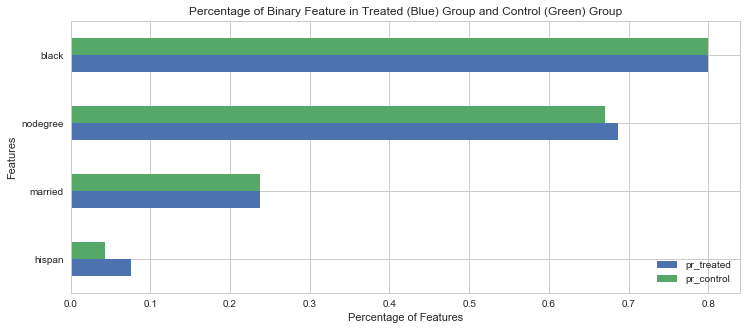

In [69]:
ax = df_temp.sort_values(["pr_treated"]).plot.barh(y=["pr_treated","pr_control"],x=["features"], figsize=(12,5))
ax.set_xlabel('Percentage of Features');
ax.set_ylabel('Features');
ax.set_title('Percentage of Binary Feature in Treated (Blue) Group and Control (Green) Group');

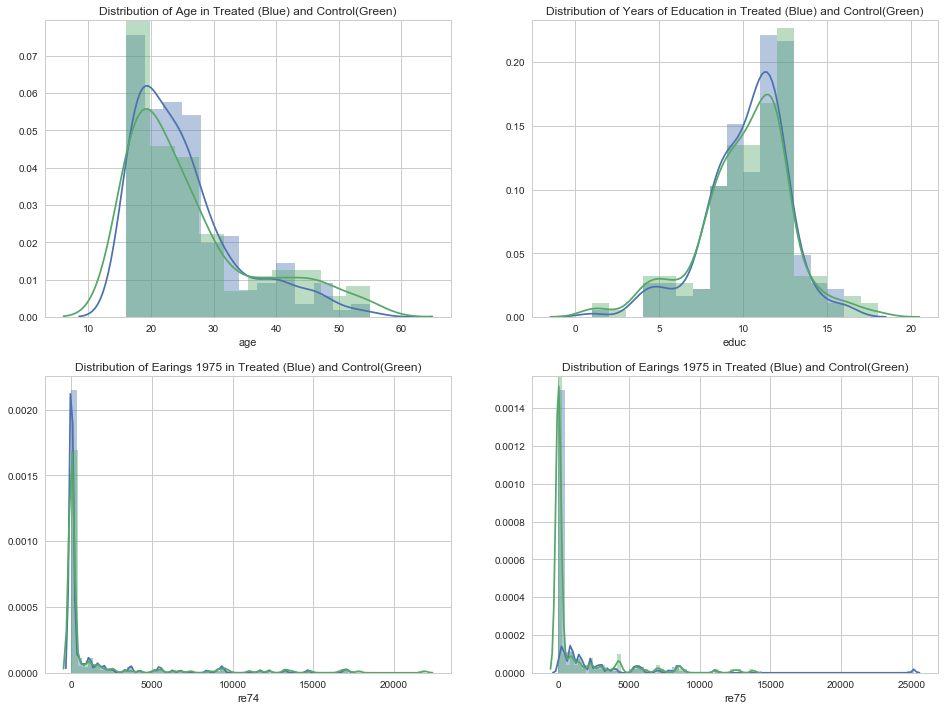

In [70]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(16, 12)

ax1 = sns.distplot(df_treated['age'], ax=ax1)
ax1 = sns.distplot(df_control['age'], ax=ax1)
ax1.set_title("Distribution of Age in Treated (Blue) and Control(Green)")

ax2 = sns.distplot(df_treated['educ'], ax=ax2)
ax2 = sns.distplot(df_control['educ'], ax=ax2)
ax2.set_title("Distribution of Years of Education in Treated (Blue) and Control(Green)")

ax3 = sns.distplot(df_treated['re74'], ax=ax3)
ax3 = sns.distplot(df_control['re74'], ax=ax3)
ax3.set_title("Distribution of Earings 1975 in Treated (Blue) and Control(Green)")

ax4 = sns.distplot(df_treated['re75'], ax=ax4)
ax4 = sns.distplot(df_control['re75'], ax=ax4)
ax4.set_title("Distribution of Earings 1975 in Treated (Blue) and Control(Green)")


### 1f. Comparison of re78 after features matching + propensity score matching

In [71]:
df_prop_merged.describe()

,re78_control,re78_treated
count,185.000000,185.000000
mean,5129.741925,5620.336424
std,6151.264578,6268.445960
min,0.000000,0.000000
25%,0.000000,33.987710
50%,2281.610000,3228.503000
75%,8546.715000,9088.018000
max,23764.800000,26817.600000


Average earning of Control group (zeros excluded):  5129.741924594595
Median earning of Control group (zeros excluded):  2281.61
Average earning of Treated group (zeros excluded):  5620.336424054055
Median earning of Treated group (zeros excluded):  3228.5029999999997


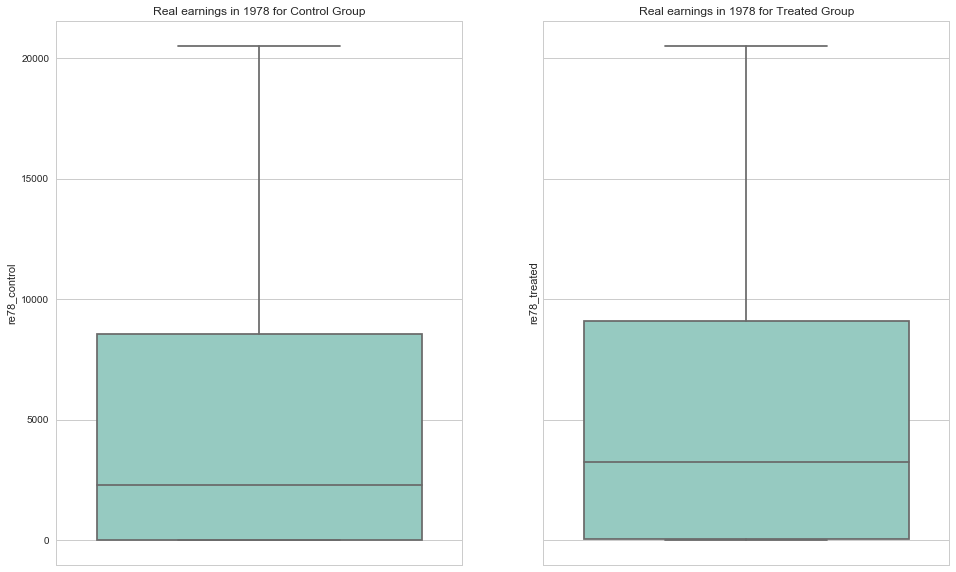

In [72]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(16, 10)
ax1 = sns.boxplot(y = 're78_control' , data=df_prop_merged, ax = ax1, palette="Set3", showfliers=False)
ax1.set_title("Real earnings in 1978 for Control Group")

ax2 = sns.boxplot(y = 're78_treated' , data=df_prop_merged, ax = ax2, palette="Set3", showfliers=False)
ax2.set_title("Real earnings in 1978 for Treated Group")

print("Average earning of Control group (zeros excluded): ",df_prop_merged['re78_control'].mean())
print("Median earning of Control group (zeros excluded): ",df_prop_merged['re78_control'].median())
print("Average earning of Treated group (zeros excluded): ",df_prop_merged['re78_treated'].mean())
print("Median earning of Treated group (zeros excluded): ",df_prop_merged['re78_treated'].median())